In [11]:
import sys, os
sys.path.append('/workspace/semantic-diffusion-model')


In [1]:
import os, glob
import numpy as np
from pathlib import Path

def get_file_list(data_dir_list, file_type, img_path="images", ann_path='bin_masks', inst_path=None, filt=None):
    """
    """

    if isinstance(data_dir_list, str): data_dir_list = [data_dir_list]

    file_list = []

    if file_type == '.png':
        for dir_path in data_dir_list:
            ext = '*.png' if filt is None else f'{filt}.png'
            image_files =  sorted(glob.glob(os.path.join(dir_path, img_path, ext)))

            if ann_path is not None:
                ann_files =  sorted(glob.glob(os.path.join(dir_path, ann_path, ext)))
            else:
                ann_files = [None] * len(image_files)

            if inst_path is not None:
                ext = '*.tif' if filt is None else f'{filt}.tif'
                inst_files =  sorted(glob.glob(os.path.join(dir_path, inst_path, ext)))
            else:
                inst_files = [None] * len(image_files)

            files = list(zip(image_files, ann_files, inst_files))

            file_list.extend(files)
            # file_list.extend(image_files)

        file_list = sorted(file_list, key=lambda x:x[0])       
        # file_list.sort()  # to always ensure same input ordering
    
    else:
        raise NotImplementedError()
    
    # Make sure all file names are the same
    for f in file_list:
        x = [Path(i).stem for i in f if i is not None]
        assert len(set(x)) == 1 and x[0] != '', f"Issue with folder containing {f}"

    return file_list




def get_file_label(gt_dirs, gt=True, img_path=None, ann_path=None, inst_path=None, filt=None):
    file_list = []
    file_labels = []


    for k, v in gt_dirs.items():
        if img_path is not None:
            f = get_file_list(v, ".png", img_path=img_path, ann_path=ann_path, inst_path=inst_path, filt=filt)
        elif gt:
            f = get_file_list(v, ".png", inst_path='inst_masks', filt=filt)
        else:
            f = get_file_list(v, ".png", img_path="samples", ann_path="labels", filt=filt)
        file_list.extend(f)
        file_labels.extend([f"{k}"] * len(f))
    
    return file_list, file_labels



In [40]:
import blobfile as bf
from PIL import Image

def load_img(path, mode='RGB', size=None):

    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert(mode)

    return pil_image


def load_ann(path, with_type=False):
    assert not with_type, "Not support"
    # assumes that ann is HxW
    with bf.BlobFile(path, "rb") as f:
        pil_class = Image.open(f)
        pil_class.load()
    pil_class = pil_class.convert("L")

    return pil_class

def load_mask(path, with_type=False):
    assert not with_type, "Not support"
    assert os.path.splitext(path)[-1] in ['.tif', '.png'], 'Mask must be .tif or update this function'
    # assumes that ann is HxW
    with bf.BlobFile(path, "rb") as f:
        pil_inst = Image.open(f)
        pil_inst.load()

    return pil_inst


In [41]:
train_dirs = {
    "train": ["/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/"],
}

train_file_list, _ = get_file_label(train_dirs, gt=True)


In [42]:
train_file_list

[('/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_000.png',
  '/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/bin_masks/TCGA-18-5592-01Z-00-DX1_000.png',
  '/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/inst_masks/TCGA-18-5592-01Z-00-DX1_000.tif'),
 ('/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_001.png',
  '/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/bin_masks/TCGA-18-5592-01Z-00-DX1_001.png',
  '/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/inst_masks/TCGA-18-5592-01Z-00-DX1_001.tif'),
 ('/mnt/dataset/MoNuSegDataset/dataset/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_002.png',
  '/mnt/dataset/MoNuSegDataset/dataset/

In [43]:
img_train = list(map(lambda x: load_img(x[0], 'RGB'), train_file_list))
mask_train = list(map(lambda x: load_mask(x[1]), train_file_list))
ann_train = list(map(lambda x: load_ann(x[2]), train_file_list))


In [26]:
import pandas as pd
from skimage import measure
from skimage.measure import regionprops
from sklearn.preprocessing import MinMaxScaler


def calculate_shape_properties(inst_mask, verbose=False):
    
    # Get properties of labeled regions
    properties = regionprops(inst_mask)
    
    if not properties:
        if verbose: print("No shapes found in the mask.")
        mean_properties = {
            'area_weighted_solidity': 1,
            'total_area': 0,
            # 'area': [prop.area for prop in properties],
            'med_area': 0,
        }

        return mean_properties

        # return None
    
    # Initialize sums for each property
    sum_solidity = 0
    sum_area = 0
        
    # Accumulate values for each property
    for prop in properties:
        sum_solidity += prop.solidity * prop.area
        sum_area += prop.area
    
    # Calculate mean values for each property
    mean_properties = {
        'area_weighted_solidity': sum_solidity / sum_area,
        'total_area': sum_area,
        # 'area': [prop.area for prop in properties],
        'med_area': np.median([prop.area for prop in properties]),
    }
    
    return mean_properties


def get_shape_properties_df(masks):

    y_prop = [calculate_shape_properties(y) for y in tqdm(masks)]

    keys = y_prop[0].keys()
    # print(keys)

    df_prop = {k:[x[k] for x in y_prop] for k in keys}
    df_prop = {k:np.array(v) for k, v in df_prop.items()}
    df_prop = pd.DataFrame.from_dict(df_prop)

    return df_prop

def get_prop_diff(df_sdm_prop, df_app_prop, quant=(.15, .85), weight = dict(med_area=.5, total_area=.5)):

    df_diff = {
        k : df_sdm_prop[k] - df_app_prop[k] for k in df_sdm_prop.keys()
    }
    df_diff = pd.DataFrame.from_dict(df_diff)

    df_diff_scaled = df_diff.abs()
    df_diff_scaled = df_diff_scaled.clip(upper=df_diff_scaled.quantile(quant[1]), axis=1)

    # print(df_diff_scaled.min(), df_diff_scaled.max())

    scaler = MinMaxScaler()
    df_diff_scaled = pd.DataFrame(scaler.fit_transform(df_diff_scaled), columns=df_diff_scaled.keys())

    # print(df_diff_scaled.min(), df_diff_scaled.max())

    df_diff_scaled['score'] = df_diff_scaled['med_area'] * .5 + df_diff_scaled['total_area'] * .5
    df_diff_scaled['prob'] = 1- df_diff_scaled['score'].clip(0, 1)

    return df_diff_scaled


In [29]:
# from guided_diffusion.data_util import get_prop_diff, get_shape_properties_df


arr_inst = [np.array(y) for y in ann_train]
mask_props = get_shape_properties_df(arr_inst)



  0%|          | 0/2368 [00:00<?, ?it/s]

In [31]:
ind = 10

prop = mask_props.iloc[ind]

diff = get_prop_diff(mask_props, prop)
indices = (-diff['prob']).argsort()[:20].to_list()
indices.remove(ind)
ind_struct = np.random.choice(indices)

print(ind, indices, ind_struct)
# self.local_images = [self.local_images[i] for i in ind]


10 [2112, 671, 2052, 2040, 1080, 2020, 1430, 628, 1604, 220, 2085, 1440, 315, 1073, 1040, 603, 594, 348, 941] 628


In [34]:
import matplotlib.pyplot as plt


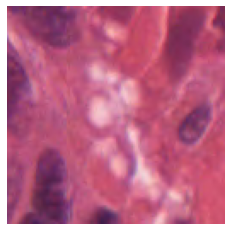

In [37]:
plt.figure()
plt.imshow(img_train[ind])
plt.axis('off')
plt.show()

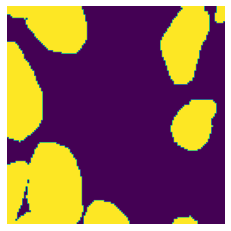

In [45]:
plt.figure()
plt.imshow(mask_train[ind])
plt.axis('off')
plt.show()

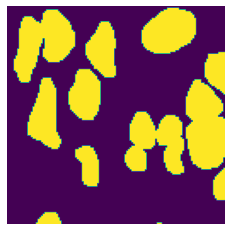

0.9916876735739762


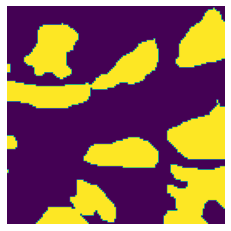

0.9900808081658627


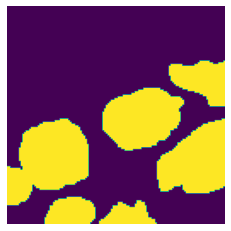

0.9883893714961469


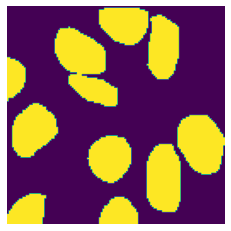

0.9877343911456089


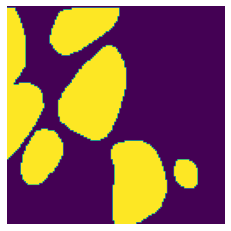

0.9876957066646048


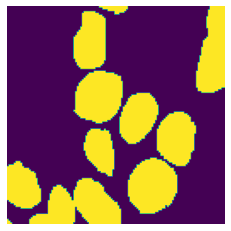

0.9868661806364578


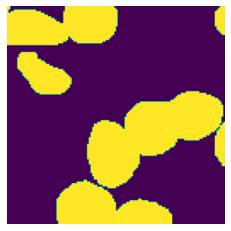

0.9861185300115449


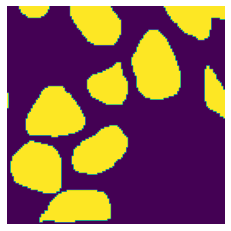

0.9858081345749988


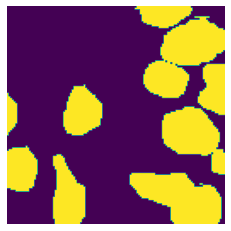

0.9851036691534822


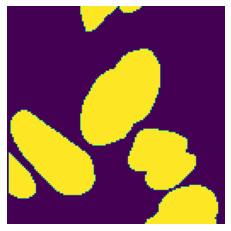

0.9845125670354435


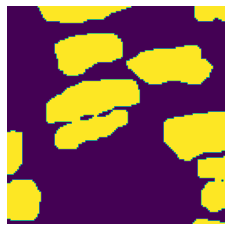

0.9814553847260907


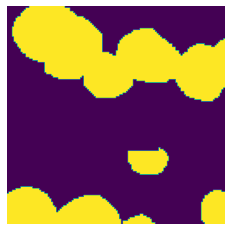

0.9786393221852144


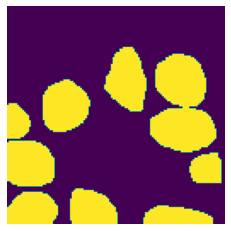

0.9775659862490567


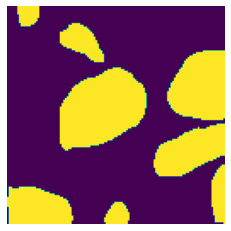

0.9760976721770824


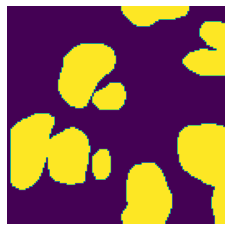

0.9760670809900168


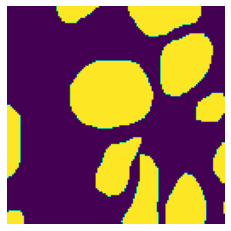

0.9744080346525567


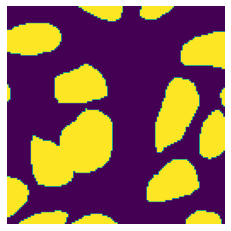

0.9743702526035647


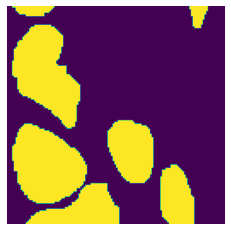

0.9727687789121874


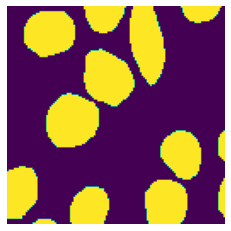

0.9726941115273816


In [48]:

for i in indices:
    plt.figure()
    plt.imshow(mask_train[i])
    plt.axis('off')
    plt.show()
    print(diff.iloc[i]['prob'])


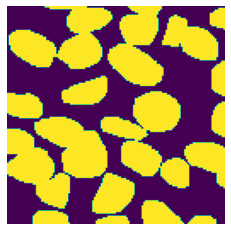

0.08697648138992864


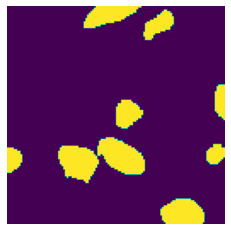

0.4789126224047372


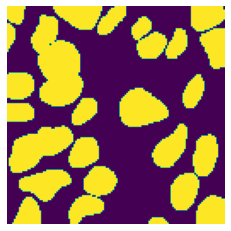

0.724698094773069


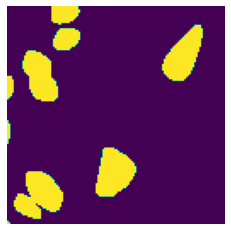

0.4845366599113855


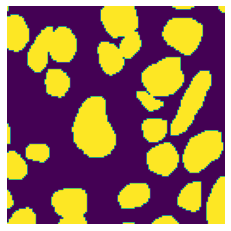

0.3923652800339007


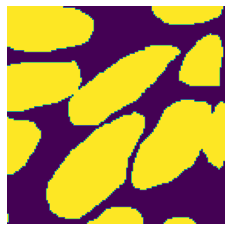

0.4134398937634618


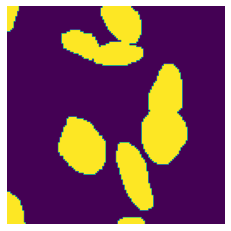

0.6604856147241795


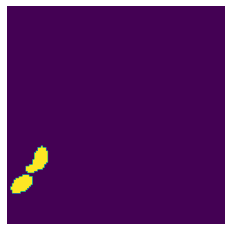

0.4389463796984566


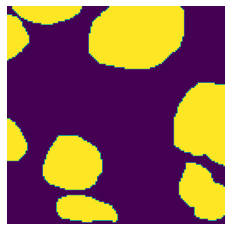

0.9286088151221976


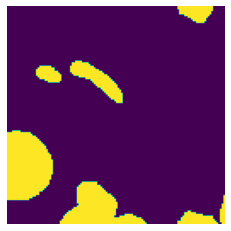

0.49901732531181764


In [50]:

for i in np.random.choice(len(mask_train), 10):
    plt.figure()
    plt.imshow(mask_train[i])
    plt.axis('off')
    plt.show()
    print(diff.iloc[i]['prob'])
